# SmartScanning

In [1]:
from enderscope import SerialUtils, Stage
# list available serial ports
ports = SerialUtils.serial_ports()
print(ports)


['/dev/ttyUSB0']


In [2]:
stage = Stage('/dev/ttyUSB0', 115200)

In [3]:
stage.home()
# move at the stage x,y center and z top position
stage.move_position([117.5,117.5,250])
stage.finish_moves()

In [ ]:
import cv2
import os
workingdir = os.path.expanduser(f'~/Pictures/')

# Capture overview image
filename = f'{workingdir}global_image.tif'
picam2.capture_file(filename)
image = cv2.imread(filename)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
resx, resy, rgb = image.shape

In [6]:
import numpy as np

def make_binary(image):
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (9, 9), -1)

    # Compute gradients using Sobel operator
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=7)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=7)

    # Combine gradient images magnitude
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)

    # Normalize and convert to 8-bit image
    grad_mag = np.uint8(grad_mag * 255.0 / np.max(grad_mag))

    # Apply thresholding to get binary image
    _, binary = cv2.threshold(grad_mag, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Optional: Perform morphological operations (e.g., closing) to clean up the image
    kernel = np.ones((5, 5), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    return binary

In [7]:
def get_objects(binary):
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    L_rect = []
    for contour in contours:
        x12, y12, w12, h12 = cv2.boundingRect(contour)
        L_rect.append(max(w12, h12))
    
    # Draw contours on the original image
    # contour_image = image.copy()
    # cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)  # -1 means draw all contours found
    
    # Calculate moments and centroids
    moments = [cv2.moments(contour) for contour in contours]
    centroids = np.array([(int(M['m10'] / M['m00']), int(M['m01'] / M['m00'])) for M in moments if M['m00'] != 0])
    return centroids, L_rect
    

In [23]:
binary = make_binary(image)
centroids, L_rect = get_objects(binary)
centroids, L_rect = tsp_sort_objects(centroids, L_rect)

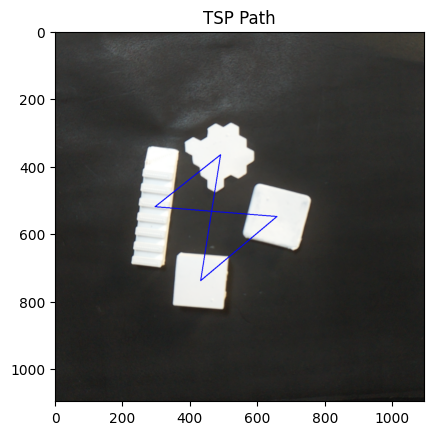

TSP Indices: [0, 1, 2, 3]


In [24]:
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

#if centroids is None or tsp_path is None or dist_matrix is None:
#    print("Error in image processing. Exiting.")
#    exit(1)

# Convert tsp_path to indices
#try:
#except Exception as e:
#    print("Error converting tsp_path to indices:", e)
#    tsp_indices = []
# Calculate distance matrix
dist_matrix = cdist(centroids, centroids, 'euclidean')
# Solve the TSP problem using the Hungarian algorithm
row_ind, col_ind = linear_sum_assignment(dist_matrix)
tsp_path = np.array([centroids[i] for i in col_ind])
tsp_indices = [np.where((centroids == coord).all(axis=1))[0][0] for coord in tsp_path]
    
# Draw TSP path on the image
tsp_image = image.copy()
for i in range(len(tsp_path) - 1):
    cv2.line(tsp_image, tuple(tsp_path[i]), tuple(tsp_path[i+1]), (255, 0, 0), 2)
cv2.line(tsp_image, tuple(tsp_path[-1]), tuple(tsp_path[0]), (255, 0, 0), 2)  # Closing the loop

plt.imshow(cv2.cvtColor(tsp_image, cv2.COLOR_BGR2RGB))
plt.title('TSP Path')
plt.show()
# Debug: Print tsp_indices
print("TSP Indices:", tsp_indices)

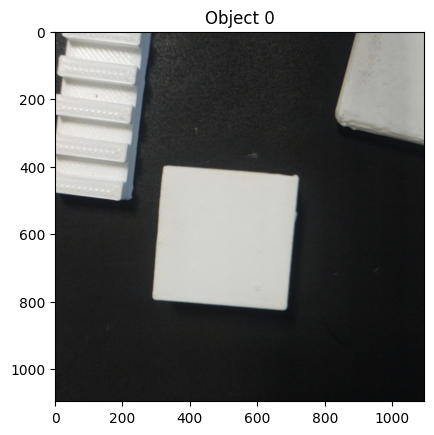

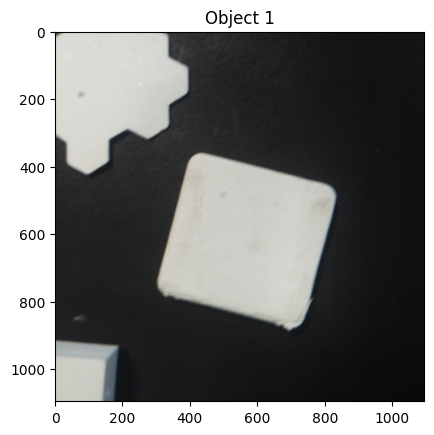

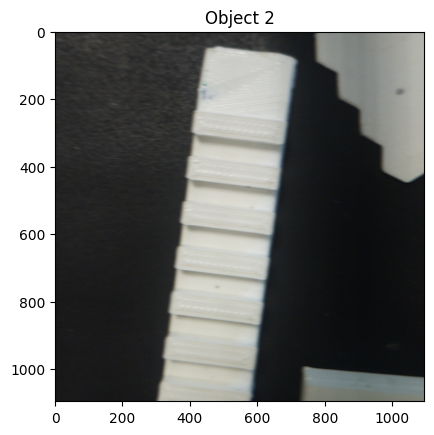

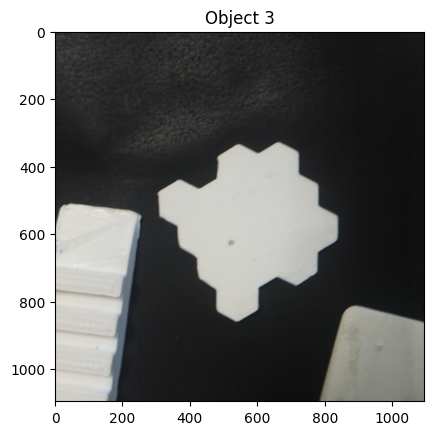

In [ ]:
# Move camera to each object centroid position
# z position is computed so that the object fills the image
from IPython.display import display
from PIL import Image as PILImage
import time


# Variables to store current positions
current_x = 0
current_y = 0
current_z = 0

scale1 = 5.95002  # pixels/mm resolution for the overview image
# Tip: re evaluate this value if you change the setup.

a1 = 182.42  # Vision size in mm at z=250mm
beta = 2 
first_move = True
for i in range(len(tsp_indices)):
    x, y = centroids[tsp_indices[i]]
    a2 = L_rect[i] / 5.95002
    go_z = (a2 - a1) / beta + 250
    go_x = -(x - resy / 2) / scale1
    go_y = (y - resx / 2) / scale1
    # print("Go_z:", go_z)
    # print ("Go_x",go_x)
    # print ("Go_y",go_y)
    
    # Calculate relative displacement from current position
    move_x = go_x - current_x
    move_y = go_y - current_y
    move_z = go_z - current_z
    stage.move_relative(move_x,move_y,-move_z)
    stage.finish_moves()
    current_x = go_x
    current_y = go_y
    current_z = go_z

    # Capture and show each object
    object_filename = f'{workingdir}object_{i}.tif'
    picam2.capture_file(object_filename)
    captured_image = cv2.imread(object_filename)
    captured_image = cv2.cvtColor(captured_image, cv2.COLOR_BGR2RGB)
    plt.imshow(captured_image)
    plt.title(f'Object {i}')
    plt.show()